In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from joblib import Parallel, delayed
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

In [3]:
df = pd.read_csv('/content/drive/MyDrive/dataset/beer_reviews.csv')

In [4]:
df.shape

(1586614, 13)

Не не не 1.5 миллиона меня уже лабы по питону убедили в этом, я не хочу это обрабатывать, поэтому возьмем рандомные 20к

In [5]:
df_sampled = df.sample(n=20000, random_state=42)

In [6]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 859964 to 1336129
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brewery_id          20000 non-null  int64  
 1   brewery_name        20000 non-null  object 
 2   review_time         20000 non-null  int64  
 3   review_overall      20000 non-null  float64
 4   review_aroma        20000 non-null  float64
 5   review_appearance   20000 non-null  float64
 6   review_profilename  19997 non-null  object 
 7   beer_style          20000 non-null  object 
 8   review_palate       20000 non-null  float64
 9   review_taste        20000 non-null  float64
 10  beer_name           20000 non-null  object 
 11  beer_abv            19181 non-null  float64
 12  beer_beerid         20000 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 2.1+ MB


In [7]:
df_sampled.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
859964,13307,Mikkeller ApS,1317606533,4.0,4.5,4.5,Ghenna,American Barleywine,3.5,3.5,Big Worst,18.5,56831
581443,126,Pete's Brewing Company,1195281294,2.5,3.0,3.5,hwwty4,Cream Ale,3.0,2.5,Pete's Wicked Wanderlust Cream Ale,5.6,19950
1270456,203,Greene King / Morland Brewery,1224109943,4.0,3.5,4.0,dsa7783,English Pale Ale,3.5,3.5,Abbot Ale,5.0,910
477415,167,Brewery Lobkowicz,1070489226,4.5,4.0,3.5,TastyTaste,Czech Pilsener,4.0,4.5,Lobkowicz Knight,4.8,444
1408999,664,Wells & Young's Ltd,1172208746,5.0,4.0,5.0,BadRockBeer,Milk / Sweet Stout,5.0,5.0,Young's Double Chocolate Stout,5.2,73


In [8]:
df_sampled = df_sampled.drop(['review_time', 'brewery_name', 'review_profilename', 'beer_beerid'], axis=1)
df_sampled.head()

,brewery_id,review_overall,review_aroma,review_appearance,beer_style,review_palate,review_taste,beer_name,beer_abv
859964,13307,4.0,4.5,4.5,American Barleywine,3.5,3.5,Big Worst,18.5
581443,126,2.5,3.0,3.5,Cream Ale,3.0,2.5,Pete's Wicked Wanderlust Cream Ale,5.6
1270456,203,4.0,3.5,4.0,English Pale Ale,3.5,3.5,Abbot Ale,5.0
477415,167,4.5,4.0,3.5,Czech Pilsener,4.0,4.5,Lobkowicz Knight,4.8
1408999,664,5.0,4.0,5.0,Milk / Sweet Stout,5.0,5.0,Young's Double Chocolate Stout,5.2


In [9]:
df_sampled.isna().sum()

,0
brewery_id,0
review_overall,0
review_aroma,0
review_appearance,0
beer_style,0
review_palate,0
review_taste,0
beer_name,0
beer_abv,819


Нам не нужно безалкогольное пиво.

In [10]:
numeric_cols = df_sampled.select_dtypes(include=['number']).columns
df_sampled[numeric_cols] = df_sampled[numeric_cols].fillna(df_sampled[numeric_cols].mean())

In [11]:
text_cols = df_sampled.select_dtypes(exclude=['number']).columns
df_sampled[text_cols] = df_sampled[text_cols].fillna('Unknow')

In [12]:
df_sampled['beer_abv'] = df_sampled['beer_abv'].fillna(df_sampled['beer_abv'].mean())

In [13]:
df_sampled.isna().sum()

,0
brewery_id,0
review_overall,0
review_aroma,0
review_appearance,0
beer_style,0
review_palate,0
review_taste,0
beer_name,0
beer_abv,0


In [14]:
top_styles = df_sampled['beer_style'].value_counts().nlargest(20).index
df_sampled = df_sampled[df_sampled['beer_style'].isin(top_styles)]

In [15]:
df_sampled.head()

,brewery_id,review_overall,review_aroma,review_appearance,beer_style,review_palate,review_taste,beer_name,beer_abv
859964,13307,4.0,4.5,4.5,American Barleywine,3.5,3.5,Big Worst,18.50
1270456,203,4.0,3.5,4.0,English Pale Ale,3.5,3.5,Abbot Ale,5.00
366834,22,3.0,2.5,3.0,Fruit / Vegetable Beer,3.0,3.0,Éphémère (Apple),5.50
1188553,10099,3.5,4.5,4.0,American Barleywine,4.0,4.0,Olde School Barleywine,15.04
38177,3268,3.5,3.5,2.5,Fruit / Vegetable Beer,2.5,3.0,Wheach,5.10


In [16]:
le = LabelEncoder()
y_encoded = le.fit_transform(df_sampled['beer_style'])

In [17]:
X = df_sampled[['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv']]
y = y_encoded

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
models = [
    LogisticRegression(),
    LogisticRegression(solver='liblinear'),
    LogisticRegression(solver='saga'),
    LogisticRegression(max_iter=200),
    RandomForestClassifier(n_estimators=100),
    RandomForestClassifier(n_estimators=50),
    RandomForestClassifier(n_estimators=10),
    RandomForestClassifier(n_estimators=200),
    RandomForestClassifier(max_depth=10),
    RandomForestClassifier(n_estimators=500),
    GradientBoostingClassifier(),
    GradientBoostingClassifier(n_estimators=50),
    GradientBoostingClassifier(n_estimators=200),
    GradientBoostingClassifier(learning_rate=0.1),
    GradientBoostingClassifier(learning_rate=0.05),
    SVC(probability=True),
    SVC(probability=True, kernel='linear'),
    SVC(probability=True, kernel='rbf'),
    SVC(probability=True, kernel='poly'),
    GaussianNB(),
    CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6)
]

In [21]:
def train_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict_proba(X_test)

In [22]:
try:
    results = Parallel(n_jobs=-1)(
        delayed(train_and_predict)(model, X_train_scaled, y_train, X_test_scaled)
        for model in tqdm.tqdm(models, desc="Обучение моделей", total=len(models))
    )
except ValueError as e:
    print(f"Ошибка при обучении моделей: {str(e)}")

Обучение моделей:  57%|█████▋    | 12/21 [00:21<00:20,  2.25s/it]/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Обучение моделей: 100%|██████████| 21/21 [02:22<00:00,  6.79s/it]


In [30]:
accuracies = []
for probs in results:
    y_pred_single = np.argmax(probs, axis=1)
    acc = accuracy_score(y_test, y_pred_single)
    accuracies.append(acc)

weights = np.array(accuracies)
weights /= weights.sum()

avg_probs = np.zeros_like(results[0])
for i, probs in enumerate(results):
    avg_probs += probs * weights[i]

y_pred = np.argmax(avg_probs, axis=1)

ensemble_accuracy = accuracy_score(y_test, y_pred)
print(f'Точность ансамбля: {ensemble_accuracy:.4f}')
print(f'Количество моделей: {len(models)}')
print(f'Лучшая точность отдельной модели: {np.max(accuracies):.4f}')
print(f'Средняя точность моделей: {np.mean(accuracies):.4f}')

Точность ансамбля: 0.3464
Количество моделей: 21
Лучшая точность отдельной модели: 0.3831
Средняя точность моделей: 0.3135


In [31]:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

results_df = pd.DataFrame({
    'Actual': y_test_labels,
    'Predicted': y_pred_labels
})

In [32]:
class_probabilities = pd.DataFrame(avg_probs, columns=le.classes_)
results_df = pd.concat([results_df, class_probabilities], axis=1)

In [33]:
print("\nПервые 20 предсказаний ансамбля:")
display(results_df.head(20))


Первые 20 предсказаний ансамбля:


,Actual,Predicted,American Adjunct Lager,American Amber / Red Ale,American Barleywine,American Double / Imperial IPA,American Double / Imperial Stout,American IPA,American Pale Ale (APA),American Porter,...,Belgian Strong Dark Ale,Belgian Strong Pale Ale,English Pale Ale,Fruit / Vegetable Beer,Hefeweizen,Märzen / Oktoberfest,Russian Imperial Stout,Saison / Farmhouse Ale,Tripel,Witbier
0,Witbier,American IPA,0.006401,0.155635,0.005370,0.029764,0.011231,0.253073,0.120488,0.056800,...,0.010552,0.023634,0.007361,0.023613,0.032846,0.054509,0.017114,0.038000,0.011243,0.086777
1,American Barleywine,Russian Imperial Stout,0.000725,0.002177,0.104506,0.130577,0.182914,0.003607,0.001158,0.014597,...,0.092697,0.035523,0.000869,0.006642,0.000747,0.001272,0.264807,0.003435,0.048440,0.002849
2,American Porter,American IPA,0.003324,0.046189,0.001720,0.008594,0.004293,0.480217,0.060366,0.136595,...,0.004533,0.008892,0.007400,0.029685,0.037903,0.044921,0.003822,0.062410,0.004228,0.020348
3,Saison / Farmhouse Ale,American Double / Imperial IPA,0.001051,0.026881,0.009873,0.172279,0.056368,0.052918,0.007102,0.113901,...,0.045135,0.100201,0.001514,0.012687,0.005260,0.006430,0.097435,0.143009,0.074024,0.007088
4,American Porter,American Pale Ale (APA),0.009520,0.184300,0.000925,0.004373,0.002473,0.050172,0.195110,0.109296,...,0.002013,0.002915,0.042985,0.031347,0.139546,0.095547,0.002171,0.016932,0.001700,0.056845
5,American Amber / Red Ale,American Pale Ale (APA),0.009418,0.230075,0.001081,0.005292,0.002843,0.066440,0.241079,0.103844,...,0.002553,0.003774,0.037476,0.032344,0.090256,0.069827,0.002668,0.019596,0.002348,0.052976
6,Märzen / Oktoberfest,American IPA,0.004162,0.152918,0.001168,0.005102,0.003197,0.158488,0.151557,0.139053,...,0.002574,0.003895,0.021545,0.067889,0.035578,0.117359,0.002313,0.035772,0.002545,0.026600
7,American Double / Imperial Stout,Russian Imperial Stout,0.000429,0.002401,0.070610,0.205923,0.089181,0.004645,0.000917,0.005861,...,0.146935,0.038153,0.000465,0.014815,0.000755,0.001207,0.253059,0.004381,0.031479,0.002939
8,American Porter,American Pale Ale (APA),0.013515,0.085354,0.001176,0.004393,0.002701,0.127459,0.320688,0.116800,...,0.002746,0.004010,0.019765,0.071160,0.069307,0.060459,0.002075,0.017013,0.002397,0.058461
9,English Pale Ale,American Adjunct Lager,0.783502,0.023114,0.000312,0.000716,0.000417,0.006459,0.028999,0.009197,...,0.000549,0.000734,0.030457,0.051205,0.025193,0.010482,0.000412,0.002523,0.000624,0.020956


In [34]:
wrong_predictions = results_df[results_df['Actual'] != results_df['Predicted']]
print(f"\nПримеры ошибок ({len(wrong_predictions)} из {len(results_df)}):")
display(wrong_predictions.head(10))


Примеры ошибок (1406 из 2151):


,Actual,Predicted,American Adjunct Lager,American Amber / Red Ale,American Barleywine,American Double / Imperial IPA,American Double / Imperial Stout,American IPA,American Pale Ale (APA),American Porter,...,Belgian Strong Dark Ale,Belgian Strong Pale Ale,English Pale Ale,Fruit / Vegetable Beer,Hefeweizen,Märzen / Oktoberfest,Russian Imperial Stout,Saison / Farmhouse Ale,Tripel,Witbier
0,Witbier,American IPA,0.006401,0.155635,0.005370,0.029764,0.011231,0.253073,0.120488,0.056800,...,0.010552,0.023634,0.007361,0.023613,0.032846,0.054509,0.017114,0.038000,0.011243,0.086777
1,American Barleywine,Russian Imperial Stout,0.000725,0.002177,0.104506,0.130577,0.182914,0.003607,0.001158,0.014597,...,0.092697,0.035523,0.000869,0.006642,0.000747,0.001272,0.264807,0.003435,0.048440,0.002849
2,American Porter,American IPA,0.003324,0.046189,0.001720,0.008594,0.004293,0.480217,0.060366,0.136595,...,0.004533,0.008892,0.007400,0.029685,0.037903,0.044921,0.003822,0.062410,0.004228,0.020348
3,Saison / Farmhouse Ale,American Double / Imperial IPA,0.001051,0.026881,0.009873,0.172279,0.056368,0.052918,0.007102,0.113901,...,0.045135,0.100201,0.001514,0.012687,0.005260,0.006430,0.097435,0.143009,0.074024,0.007088
4,American Porter,American Pale Ale (APA),0.009520,0.184300,0.000925,0.004373,0.002473,0.050172,0.195110,0.109296,...,0.002013,0.002915,0.042985,0.031347,0.139546,0.095547,0.002171,0.016932,0.001700,0.056845
5,American Amber / Red Ale,American Pale Ale (APA),0.009418,0.230075,0.001081,0.005292,0.002843,0.066440,0.241079,0.103844,...,0.002553,0.003774,0.037476,0.032344,0.090256,0.069827,0.002668,0.019596,0.002348,0.052976
6,Märzen / Oktoberfest,American IPA,0.004162,0.152918,0.001168,0.005102,0.003197,0.158488,0.151557,0.139053,...,0.002574,0.003895,0.021545,0.067889,0.035578,0.117359,0.002313,0.035772,0.002545,0.026600
7,American Double / Imperial Stout,Russian Imperial Stout,0.000429,0.002401,0.070610,0.205923,0.089181,0.004645,0.000917,0.005861,...,0.146935,0.038153,0.000465,0.014815,0.000755,0.001207,0.253059,0.004381,0.031479,0.002939
8,American Porter,American Pale Ale (APA),0.013515,0.085354,0.001176,0.004393,0.002701,0.127459,0.320688,0.116800,...,0.002746,0.004010,0.019765,0.071160,0.069307,0.060459,0.002075,0.017013,0.002397,0.058461
9,English Pale Ale,American Adjunct Lager,0.783502,0.023114,0.000312,0.000716,0.000417,0.006459,0.028999,0.009197,...,0.000549,0.000734,0.030457,0.051205,0.025193,0.010482,0.000412,0.002523,0.000624,0.020956


In [35]:
good_predictions = results_df[results_df['Actual'] == results_df['Predicted']]
display(good_predictions.head(10))

,Actual,Predicted,American Adjunct Lager,American Amber / Red Ale,American Barleywine,American Double / Imperial IPA,American Double / Imperial Stout,American IPA,American Pale Ale (APA),American Porter,...,Belgian Strong Dark Ale,Belgian Strong Pale Ale,English Pale Ale,Fruit / Vegetable Beer,Hefeweizen,Märzen / Oktoberfest,Russian Imperial Stout,Saison / Farmhouse Ale,Tripel,Witbier
12,American Adjunct Lager,American Adjunct Lager,0.548905,0.040444,0.000446,0.001354,0.000739,0.013897,0.098724,0.024011,...,0.000829,0.001016,0.075704,0.072327,0.035270,0.018962,0.000714,0.003795,0.000856,0.054730
20,American IPA,American IPA,0.007389,0.078839,0.001984,0.009154,0.003766,0.431386,0.104855,0.060750,...,0.004451,0.017062,0.020126,0.038174,0.022877,0.031370,0.004722,0.031674,0.005931,0.039982
23,American IPA,American IPA,0.002447,0.048629,0.002506,0.014907,0.006127,0.537962,0.052585,0.078780,...,0.007023,0.015322,0.005294,0.019011,0.012865,0.025946,0.007401,0.091646,0.006967,0.013368
24,American Pale Ale (APA),American Pale Ale (APA),0.003810,0.068384,0.001165,0.007610,0.005575,0.089194,0.276286,0.096915,...,0.002497,0.003697,0.019971,0.053264,0.209407,0.024245,0.003119,0.028147,0.002026,0.050982
28,American Amber / Red Ale,American Amber / Red Ale,0.020370,0.237991,0.000658,0.002827,0.001521,0.044234,0.157321,0.033410,...,0.001198,0.001923,0.108332,0.088549,0.140074,0.058758,0.001790,0.015314,0.001341,0.051409
29,Russian Imperial Stout,Russian Imperial Stout,0.000378,0.002435,0.056708,0.134674,0.109777,0.004744,0.000847,0.006613,...,0.177143,0.034182,0.000427,0.009719,0.000659,0.000755,0.335428,0.003940,0.029597,0.001724
33,American Pale Ale (APA),American Pale Ale (APA),0.061869,0.104891,0.000862,0.002990,0.001863,0.058852,0.156169,0.107644,...,0.001609,0.002259,0.085693,0.119635,0.112615,0.064006,0.001784,0.012638,0.001677,0.070750
36,American Double / Imperial Stout,American Double / Imperial Stout,0.001471,0.038899,0.006762,0.071719,0.165768,0.149350,0.012567,0.105972,...,0.047510,0.067901,0.002730,0.014530,0.007894,0.009281,0.024258,0.143387,0.052261,0.009069
40,American IPA,American IPA,0.001348,0.039226,0.002457,0.014350,0.006999,0.566795,0.066782,0.078206,...,0.006687,0.010867,0.005481,0.026706,0.013240,0.013479,0.005640,0.078425,0.005765,0.016298
43,American IPA,American IPA,0.001528,0.116074,0.003111,0.020027,0.010660,0.589851,0.026382,0.050074,...,0.009105,0.021234,0.002987,0.015018,0.008581,0.013589,0.009546,0.043305,0.008454,0.009968


Выведем матрицу корелляций

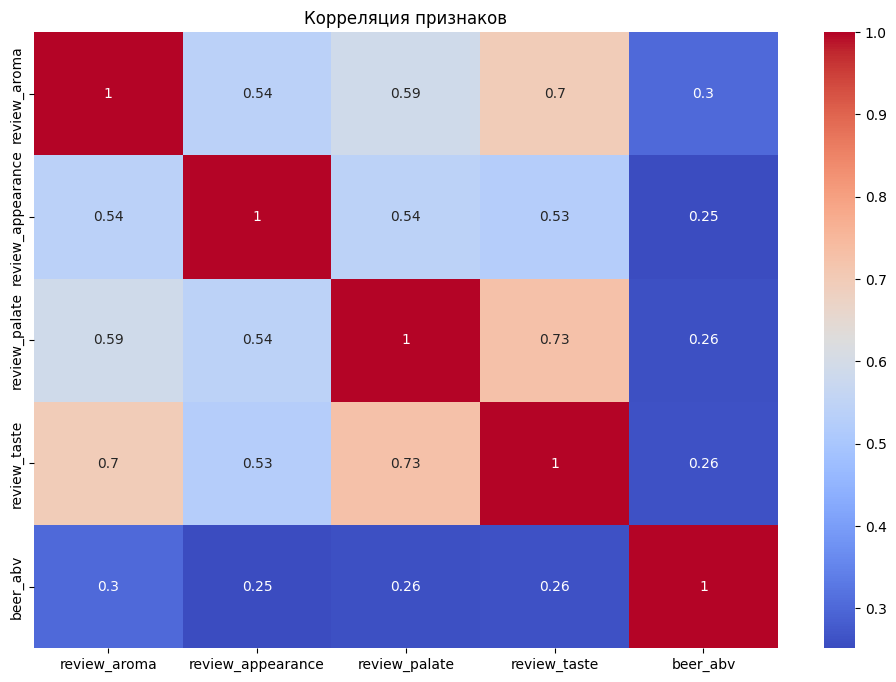

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

if isinstance(X_train, pd.DataFrame):
    plt.figure(figsize=(12, 8))
    sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
    plt.title("Корреляция признаков")
    plt.show()

И заметим, что алкогольность почти не зависит от оценок людей =(